In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [37]:
# Take a look at what we are working with
df_train.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
id        300000 non-null int64
bin_0     300000 non-null int64
bin_1     300000 non-null int64
bin_2     300000 non-null int64
bin_3     300000 non-null object
bin_4     300000 non-null object
nom_0     300000 non-null object
nom_1     300000 non-null object
nom_2     300000 non-null object
nom_3     300000 non-null object
nom_4     300000 non-null object
nom_5     300000 non-null object
nom_6     300000 non-null object
nom_7     300000 non-null object
nom_8     300000 non-null object
nom_9     300000 non-null object
ord_0     300000 non-null int64
ord_1     300000 non-null object
ord_2     300000 non-null object
ord_3     300000 non-null object
ord_4     300000 non-null object
ord_5     300000 non-null object
day       300000 non-null int64
month     300000 non-null int64
target    300000 non-null int64
dtypes: int64(8), object(17)
memory usage: 57.2+ MB


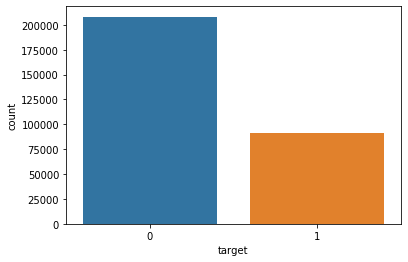

In [39]:
# Count plot to see how the target classification is distributed
sns.countplot(x='target',data=df_train)

Although it's not evenly distributed, the target is binary making it easy to apply our method. 

# Build Models Using Get Dummies on Every Column

In [40]:
# Combine test and train in order to ensure they have the same columns from get_dummies
# Note: This is a short coming of get_dummies, this method is a popular one but can cause leakage
df_train['IsTrain'] = 1
df_test['IsTrain'] = 0
df_full = pd.concat([df_train,df_test])

# Save Test IDs for later
test_ids = df_test['id']

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [41]:
# Drop any column with more than 50 unique items it will be too hard to use dummy variables on them
for col in  df_full.columns:
    if len(df_full[col].unique()) > 300:
        df_full.drop(col, axis =1, inplace = True)
        print (col)
        
# Get Dummies on the rest of the columns left over
df_full = pd.get_dummies(df_full, drop_first = True)

id
nom_6
nom_7
nom_8
nom_9


In [42]:
len(df_full.columns)

490

The amount of columns created from get dummies is extremley high but these extreme cases are what we are trying to test.

In [44]:
# Split the data back out
df_train = df_full[df_full['IsTrain']==1]
df_train.drop('IsTrain', axis = 1,inplace = True)
df_test = df_full[df_full['IsTrain']==0]
df_test.drop('IsTrain', axis = 1, inplace = True)
df_test.drop('target',axis = 1, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
# Split out independent varialbles
y = df_train['target']
X = df_train.drop('target', axis = 1)
#X.drop('id',inplace=True,axis = 1)

# Save id for the test set and drop it for testing later
#df_test.drop('id',axis = 1, inplace = True)

## Build Some Basic Models

In [46]:
# Split into Test and Train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3)

In [47]:
# Train on Logistic Regression & Random Forest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()

# Fit to training data
model_lr.fit(X_train,y_train)
model_rf.fit(X_train,y_train)

# Apply to test
pred_lr = model_lr.predict(X_test)
pred_rf = model_rf.predict(X_test)

# Get AUC Score
from sklearn.metrics import roc_auc_score
print(f"Logistic Regression AUC: {roc_auc_score(y_test, pred_lr)} Random Forest: {roc_auc_score(y_test, pred_rf)}")

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression AUC: 0.6475540693848003 Random Forest: 0.5524940769511568


In [ ]:
features = dict()
for feature, importance in zip(X.columns, model_xg.feature_importances_):
    features[feature] = importance
features  = pd.DataFrame(features, index = [0])

## Build More Complex ML Methods

In [28]:
# XGBoost
from xgboost import XGBClassifier
model_xg = XGBClassifier()
model_xg.fit(X_train,y_train)
pred_xg = model_xg.predict(X_test)

print(f"XGBoost AUC: {roc_auc_score(y_test, pred_xg)}")

XGBoost AUC: 0.5519167074698813


In [131]:
# Artificial Neural Network (TensofFlow)

# Build Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

model = Sequential()

model.add(Dense(units=490,activation='relu'))
model.add(Dropout(0.5)) # Use Drop out so it can be comapred later even though this probably wont effect our model
model.add(Dense(units=245,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=50,activation='relu'))
model.add(Dropout(0.5))
# BINARY CLASSIFICATION uses sigmoid
model.add(Dense(units=1,activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam')


In [132]:
# Use early stop to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model.fit(x=X_train.values, 
          y=y_train.values, 
          epochs=50, 
          validation_data=(X_test.values, y_test.values), 
          verbose=1,
          batch_size=256,
          callbacks=[early_stop]
          )

Train on 210000 samples, validate on 90000 samples
Epoch 1/50
210000/210000 [==============================] - 3s 13us/sample - loss: 0.5530 - val_loss: 0.5022
Epoch 2/50
210000/210000 [==============================] - 3s 12us/sample - loss: 0.4931 - val_loss: 0.4732
Epoch 3/50
210000/210000 [==============================] - 3s 13us/sample - loss: 0.4744 - val_loss: 0.4639
Epoch 4/50
210000/210000 [==============================] - 3s 12us/sample - loss: 0.4669 - val_loss: 0.4563
Epoch 5/50
210000/210000 [==============================] - 2s 11us/sample - loss: 0.4639 - val_loss: 0.4707
Epoch 6/50
210000/210000 [==============================] - 2s 10us/sample - loss: 0.4628 - val_loss: 0.4591
Epoch 7/50
210000/210000 [==============================] - 2s 12us/sample - loss: 0.4608 - val_loss: 0.4684
Epoch 8/50
210000/210000 [==============================] - 2s 11us/sample - loss: 0.4610 - val_loss: 0.4534
Epoch 9/50
210000/210000 [==============================] - 2s 10us/sample - 

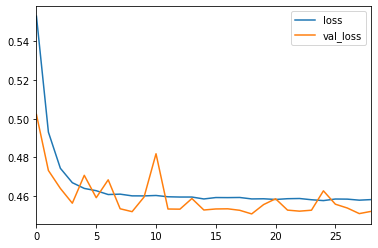

In [133]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [134]:
predictions = model.predict(X_test)
roc_auc_score(y_test,predictions)

0.8340604255101647

## Fit to Test Data

Fit our best moden (Artificial Neural Networks) to the tes data to test data to see if our data was overfit

In [64]:
# Test Base Level
final = model.predict(df_test)

In [62]:
df_test.drop('target',inplace=True, axis = 1)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [83]:
# Print results
submission = pd.DataFrame({'id': test_ids.values, 'target': final.ravel()})
submission.to_csv('submission.csv', index=False)

Result from Kaggle: 

# Develop Logic for Replacing Categorical Attributes

Now lets see if the new methodology of replacing categorial fields with ranked numbers improves our score

In [185]:
# Reload the data for a fresh start
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [87]:
for col in df_train.columns:
    if col not in ['id','target']:
        replacements = dict()
        replacements = df_train.groupby(col).sum()['target']/df_train.groupby([col]).count()['target']
        replacements = replacements.to_dict()
        df_train[col] = df_train[col].map(replacements)
        # Also Apply to test data
        df_test[col] = df_test[col].map(replacements)

In [245]:
df_train

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0
5,5,0,1,1,T,N,Blue,Polygon,Lion,Costa Rica,...,51e27c16d,1,Novice,Freezing,j,E,PZ,2,2,0
6,6,0,1,1,T,N,Green,Trapezoid,Cat,China,...,7e3d79a0d,2,Grandmaster,Lava Hot,g,P,wy,5,4,0
7,7,1,0,1,T,Y,Red,Triangle,Dog,Russia,...,feb72ecc2,1,Novice,Lava Hot,j,K,Ed,4,2,0
8,8,1,0,1,T,Y,Blue,Square,Hamster,Canada,...,34a7273bf,2,Novice,Boiling Hot,e,V,qo,3,4,0
9,9,0,0,0,F,Y,Red,Trapezoid,Lion,China,...,0ece7a511,1,Expert,Freezing,h,Q,CZ,3,2,0


In [90]:
# Check test data for nulls (this would be due to new categories)
nulls= df_test.isnull().sum()
print(nulls[nulls > 0])

nom_8      8
nom_9    144
dtype: int64


In [92]:
# Replace with the mode so that a new category is not created
df_test['nom_8'].fillna(df_test['nom_8'].mode()[0], inplace=True)
df_test['nom_9'].fillna(df_test['nom_9'].mode()[0], inplace=True)

In [95]:
y = df_train['target']
X = df_train.drop('target', axis = 1)
X.drop('id', axis = 1, inplace = True)

# See if Basic Models Improve

In [174]:
# Split into Test and Train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3)

In [97]:
# Train on Logistic Regression & Random Forest
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()

# Fit to training data
model_lr.fit(X_train,y_train)
model_rf.fit(X_train,y_train)

# Apply to test
pred_lr = model_lr.predict(X_test)
pred_rf = model_rf.predict(X_test)

# Get AUC Score
from sklearn.metrics import roc_auc_score
print(f"Logistic Regression AUC: {roc_auc_score(y_test, pred_lr)} Random Forest: {roc_auc_score(y_test, pred_rf)}")

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression AUC: 0.7114479527059432 Random Forest: 0.636375062616791


Both have sigificant increases and much less time! But we are actually hoping for a better performance with more complex models. So next step will to be to test how it interacts with bag, boosting, and dropout layers.

# Complex ML Models w/ New Categorical Method

In [98]:
# XGBoost
from xgboost import XGBClassifier
model_xg = XGBClassifier()
model_xg.fit(X_train,y_train)
pred_xg = model_xg.predict(X_test)

print(f"XGBoost AUC: {roc_auc_score(y_test, pred_xg)}")

XGBoost AUC: 0.6658686461850265


In [172]:
df_train.drop('ord_5', inplace= True, axis =1 )

In [176]:
# Artificial Neural Network (TensofFlow)

# Build Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

model = Sequential()

model.add(Dense(units=21,activation='relu'))
model.add(Dropout(0.5)) 
# Use Drop out so it can be comapred later even though this probably wont effect our model
# BINARY CLASSIFICATION uses sigmoid
model.add(Dense(units=1,activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam')

In [177]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model.fit(x=X_train.values, 
          y=y_train.values, 
          epochs=100, 
          validation_data=(X_test.values, y_test.values), 
          verbose=1,
          batch_size=256,
          callbacks=[early_stop]
          )

Train on 210000 samples, validate on 90000 samples
Epoch 1/100
210000/210000 [==============================] - 2s 8us/sample - loss: 0.6176 - val_loss: 0.5874
Epoch 2/100
210000/210000 [==============================] - 1s 6us/sample - loss: 0.5752 - val_loss: 0.5518
Epoch 3/100
210000/210000 [==============================] - 1s 7us/sample - loss: 0.5515 - val_loss: 0.5317
Epoch 4/100
210000/210000 [==============================] - 2s 10us/sample - loss: 0.5347 - val_loss: 0.5126
Epoch 5/100
210000/210000 [==============================] - 1s 7us/sample - loss: 0.5224 - val_loss: 0.5010
Epoch 6/100
210000/210000 [==============================] - 1s 7us/sample - loss: 0.5129 - val_loss: 0.4930
Epoch 7/100
210000/210000 [==============================] - 1s 7us/sample - loss: 0.5059 - val_loss: 0.4839
Epoch 8/100
210000/210000 [==============================] - 1s 7us/sample - loss: 0.4996 - val_loss: 0.4768
Epoch 9/100
210000/210000 [==============================] - 1s 7us/sample -

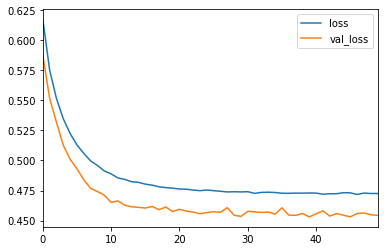

In [179]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [180]:
predictions = model.predict(X_test)
roc_auc_score(y_test,predictions)

0.8334486986132379

# Export to be Evaluated

In [106]:
df_test.drop('id', inplace= True, axis =1 )

In [154]:
# Test Base Level
final = model.predict(df_test)
#pred_lf = model_rf.predict(cat_test)

In [155]:
# Print results
submission = pd.DataFrame({'id': test_ids.values, 'target': final.ravel()})
submission.to_csv('submission.csv', index=False)